# Continuous Control

This notebook implements a DDPG to solve the Reacher environment from Unity Environment.

### 1. Start the Environment

Import the necessary packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### Import the modules to implement the agent

#### Import the DDPG agent from the dqn_agent module


In [5]:
import torch
from replaybuffer import ReplayBuffer
from collections import deque
from ddpg_agent import Agent
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Function to train the DDPG agent

The successful agent is saved in the checkpoint.pth file in the same directory of this notebook.


In [6]:
def ddpg(agent, n_episodes=1500, max_t=4000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state[0])
            env_info = env.step(np.asarray([action]))[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state[0], action, reward[0], next_state[0], done[0])
            state = next_state
            score += reward[0]
            if done[0]:
                break 
        scores_deque.append(score)
        scores.append(score)
        
        #print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque), end=""))
        if i_episode % print_every == 0:
            print('\rEpisode {}\ Average Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 30:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

#### Training the Agent...

In [7]:
SEED = 2
BATCH_SIZE = 128
BUFFER_SIZE = int(1e5)
UPDATE_FREQ = 5

replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, SEED, device)

agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED, memory=replay_buffer,
                 update_every=UPDATE_FREQ, device=device)
    

total_scores = ddpg(agent)

/home/mauro/Dev/ReinforcementLearnig/UdacityRL/course/deep-reinforcement-learning/p2_continuous-control/SingleAgent/ddpg_agent.py:108: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 100\ Average Score: 3.04
Episode 200\ Average Score: 8.65
Episode 300\ Average Score: 20.31
Episode 400\ Average Score: 23.75
Episode 500\ Average Score: 28.18
Episode 600\ Average Score: 21.57
Episode 700\ Average Score: 22.73
Episode 800\ Average Score: 16.25
Episode 900\ Average Score: 15.34
Episode 1000\ Average Score: 22.87
Episode 1100\ Average Score: 23.17
Episode 1200\ Average Score: 24.24
Episode 1300\ Average Score: 18.40
Episode 1400\ Average Score: 20.71

Environment solved in 1394 episodes!	Average Score: 30.02


#### Training process

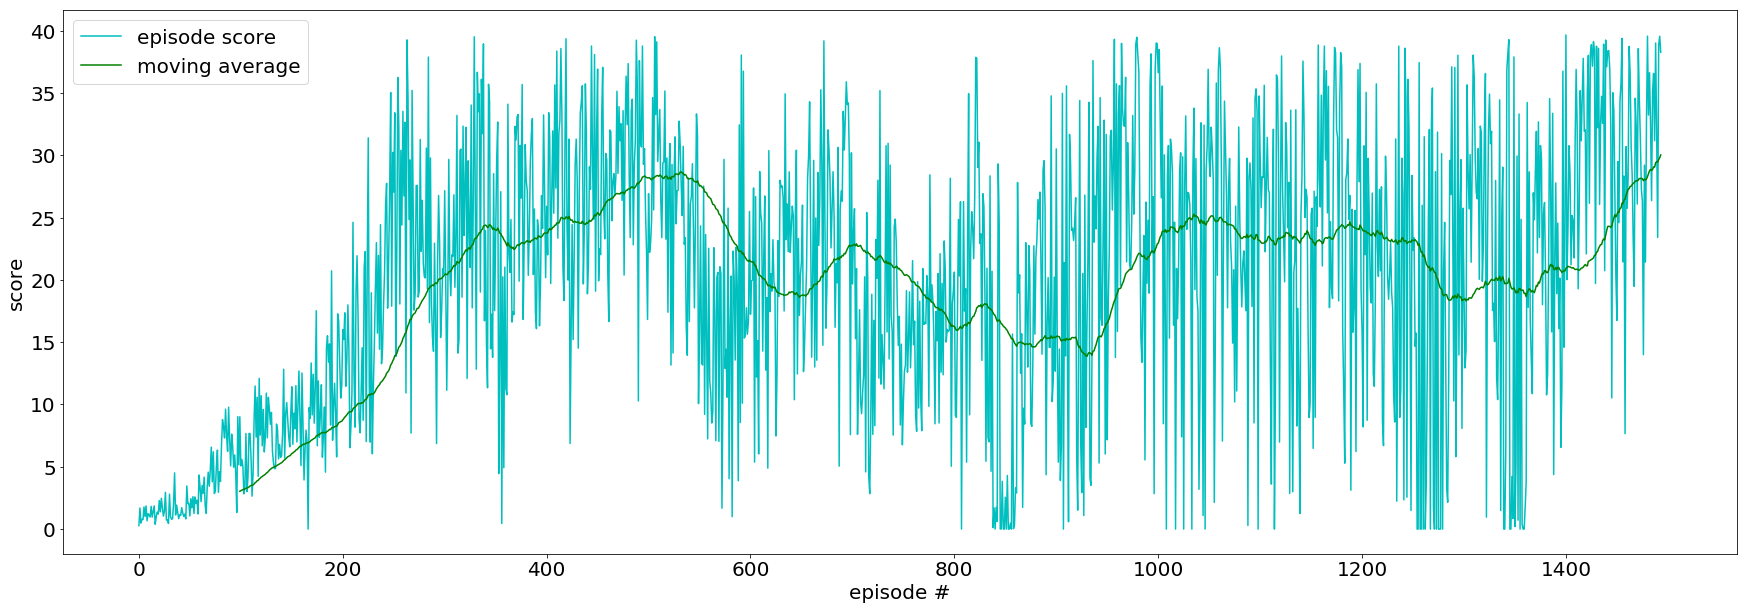

In [35]:
import pandas as pd

fig = plt.figure(figsize=(30,10))
plt.plot(np.arange(len(total_scores)), total_scores, '-c', label='episode score')
moving_average = pd.Series(total_scores).rolling(100).mean()
plt.plot(np.arange(len(total_scores)), moving_average, '-g', label='moving average')
plt.ylabel("score", fontsize=20)
plt.xlabel("episode #", fontsize=20)
plt.rcParams.update({'font.size': 20})
plt.legend()
plt.show()